In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import OneHotEncoder
import datetime as dt

In [2]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical
import keras 

In [3]:
def add_date_data(DF):
    DF_dates=pd.DataFrame({'date':DF.date.unique(),'year':0,'year_week':0,
                          'month':0,'month_day':0,
                          'year_day':0,'weekday':0,
                          'week':0})

    for ind in DF_dates.index:
        date=DF_dates.date[ind]
        date_st=date.timetuple()
        DF_dates.loc[ind,'year']=date_st.tm_year
        DF_dates.loc[ind,'month']=date_st.tm_mon
        DF_dates.loc[ind,'month_day']=date_st.tm_mday
        DF_dates.loc[ind,'year_day']=date_st.tm_yday
        DF_dates.loc[ind,'weekday']=date_st.tm_wday
        DF_dates.loc[ind,'year_week']=date.isocalendar()[0]
        DF_dates.loc[ind,'week']=date.isocalendar()[1]
        
        
    DF=DF.merge(DF_dates, on='date')
    return DF

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([0, len(loss)+5, 0, 1.1*max(max(loss),max(val_loss))])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

# Import Data.
## Energy Generated

In [4]:
Energy=pd.read_csv('../../Data/subsystem_all_dams/Energy_generated_daily_by_dam.csv.zip')
Energy=Energy.groupby('date').sum('energy_generated').reset_index()
Energy['date']=pd.to_datetime(Energy.date)

## Demand (whole subsystem) and Influent Flow per dam. 

In [5]:
DF=pd.read_csv('../../Data/subsystem_all_dams/Selected_important_dams_energy_demand_flow.csv.zip')
DF=DF[['date', 'influent_flow', 'energy_generated', 'maximum_demand','dam']]
DF['date']=pd.to_datetime(DF.date)

In [6]:
Demand=DF[['date','maximum_demand']].groupby('date').max().reset_index()

Flows=DF[['date','dam','influent_flow']].pivot(index='date', columns='dam', values='influent_flow')#.reset_index()
Flows.columns=['Flow_'+x.lower().replace(' ','_') for x in Flows.columns]
Flows=Flows.reset_index()
Flows['date']=pd.to_datetime(Flows.date)

In [7]:
#Combine all:
Dates=pd.DataFrame({'date':pd.date_range(start='2000-01-01', end='2019-12-31')})
Complete_DF=Dates.merge(Energy, how='left', on='date').\
                    merge(Demand, how='left', on='date').\
                    merge(Flows,how='left', on='date')
Complete_DF=Complete_DF.sort_values('date')
Complete_DF=add_date_data(Complete_DF)

In [8]:
agg_dict={flow:'mean' for flow in Flows.columns if 'Flow' in flow}
agg_dict['date']='max'; agg_dict['month']=pd.Series.mode
agg_dict['energy_generated']='sum'; agg_dict['maximum_demand']='sum'
Complete_DF=Complete_DF.groupby(['year_week','week']).agg(agg_dict).reset_index()

In [9]:
Month=pd.DataFrame(OneHotEncoder(sparse=False).fit_transform(Complete_DF[['month']]))
Complete_DF=pd.concat([Complete_DF.drop(['month', 'year_week', 'week'], axis=1),Month],axis=1)

## Rain data by state 

In [10]:
Rain1=pd.read_csv('../../Data/weekly_rain_by_state_data.csv',index_col=0)
Rain1['date']=pd.to_datetime(Rain1.date)

In [11]:
Complete_DF=Complete_DF.merge(Rain1, on='date', how='left')

## Rescale the data

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler_energy_demand=StandardScaler()
scaler_flow=StandardScaler()
scaler_rain=MinMaxScaler()

Scaled_DF=pd.DataFrame()
Scaled_DF['date']=Complete_DF['date']
Scaled_DF[list(range(12))]=Complete_DF[list(range(12))]
Scaled_DF[['energy_generated','maximum_demand']]=\
        scaler_energy_demand.fit_transform(Complete_DF[['energy_generated','maximum_demand']])
Scaled_DF[[name for name in Flows.columns if name!='date']]=\
        scaler_flow.fit_transform(Complete_DF[[name for name in Flows.columns if name!='date']])
Scaled_DF[[name for name in Rain1.columns if name!='date']]=\
        scaler_rain.fit_transform(Complete_DF[[name for name in Rain1.columns if name!='date']])

# Try a Regular Neural Net

## Using only Demand and Influent Flow

In [15]:
date_train='2016-01-01'
date_validate='2018-01-01'
date_test='2019-12-31'

DF=Scaled_DF.copy()
DF=DF.drop([name for name in DF.columns if 'rain' in str(name)],axis=1)
DF=DF.dropna(thresh=DF.shape[1]-3).fillna(0)

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date','energy_generated'],axis=1))
y_train=np.array(DF_train['energy_generated'])

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date','energy_generated'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date','energy_generated'],axis=1))
y_test=np.array(DF_test['energy_generated'])

In [16]:
model = models.Sequential()
model.add(layers.Dense(50,input_shape=[X_train.shape[1]]))
model.add(layers.Dense(50))
model.add(layers.Dense(50))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mae', metrics=['mae'])

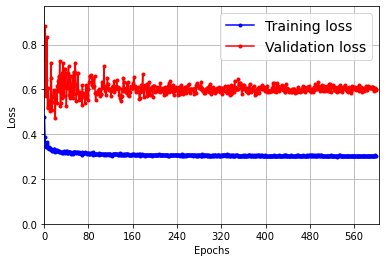

In [17]:
history = model.fit(X_train,y_train,epochs = 600,validation_data=(X_validate,y_validate), verbose=0)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

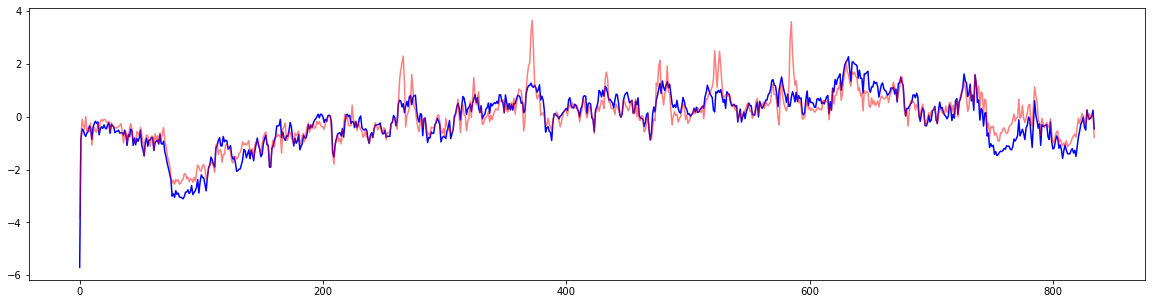

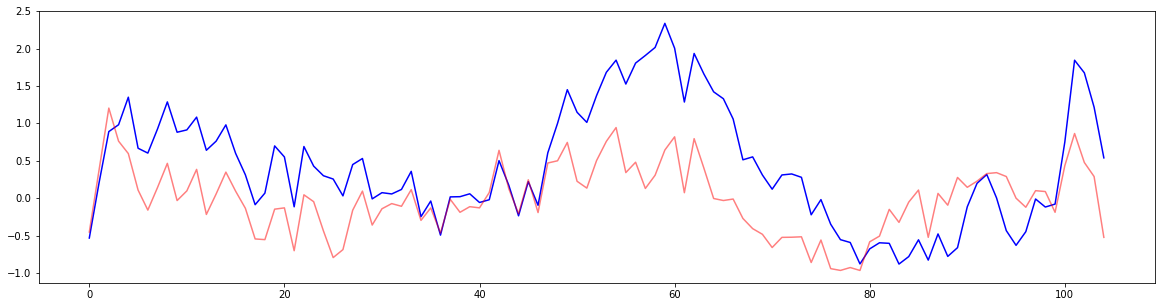

0.785625902696794


In [18]:
y_pred=model.predict(X_train)
plt.figure(figsize=(20,5))
plt.plot(y_train,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()


y_pred=model.predict(X_validate)
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()

print(np.mean(np.abs((y_pred-y_validate))))

## Using only Demand and Rain

In [19]:
date_train='2016-01-01'
date_validate='2018-01-01'
date_test='2019-12-31'

DF=Scaled_DF.copy()
DF=DF.drop([name for name in DF.columns if 'Flow' in str(name)],axis=1).fillna(0)
DF=DF.dropna(thresh=DF.shape[1]-2).fillna(0)

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date','energy_generated'],axis=1))
y_train=np.array(DF_train['energy_generated'])

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date','energy_generated'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date','energy_generated'],axis=1))
y_test=np.array(DF_test['energy_generated'])

In [20]:
model = models.Sequential()
model.add(layers.Dense(50,input_shape=[X_train.shape[1]]))
model.add(layers.Dense(50))
model.add(layers.Dense(50))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mae', metrics=['mae'])

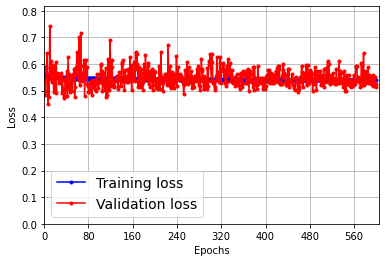

In [21]:
history = model.fit(X_train,y_train,epochs = 600,validation_data=(X_validate,y_validate), verbose=0)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

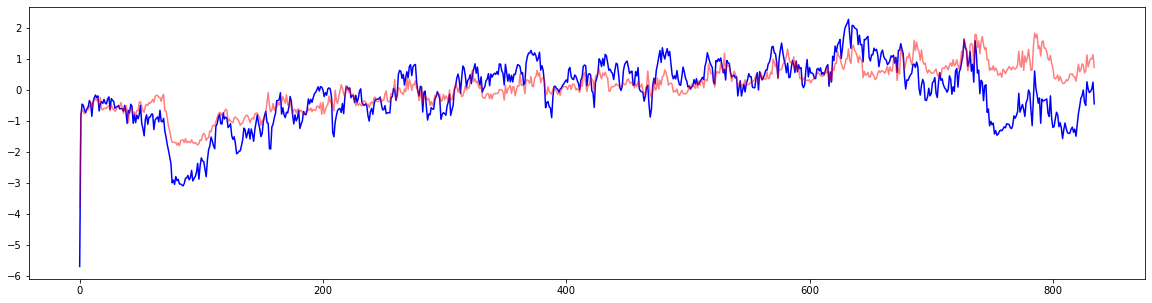

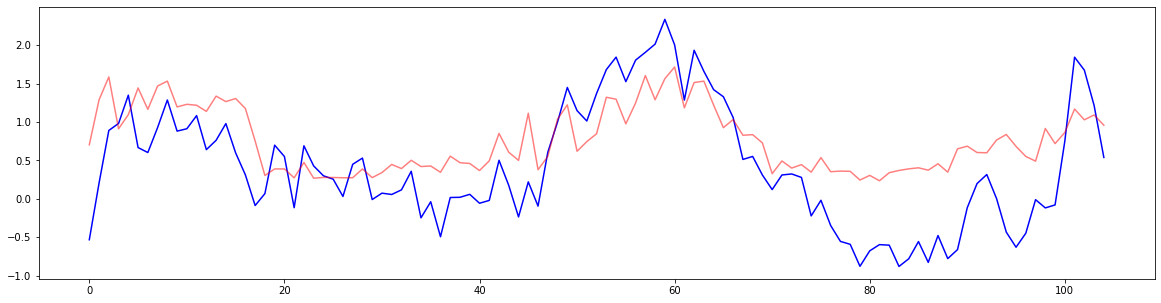

0.7748696928509887


In [22]:
y_pred=model.predict(X_train)
plt.figure(figsize=(20,5))
plt.plot(y_train,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()


y_pred=model.predict(X_validate)
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()

print(np.mean(np.abs((y_pred-y_validate))))

## Using only Rain and Month

In [23]:
date_train='2016-01-01'
date_validate='2018-01-01'
date_test='2019-12-31'

DF=Scaled_DF.copy()
DF=DF.drop([name for name in DF.columns if 'Flow' in str(name)],axis=1)
DF=DF.drop(['maximum_demand'],axis=1)
DF=DF.dropna(thresh=DF.shape[1]-2).fillna(0)

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date','energy_generated'],axis=1))
y_train=np.array(DF_train['energy_generated'])

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date','energy_generated'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date','energy_generated'],axis=1))
y_test=np.array(DF_test['energy_generated'])

In [24]:
model = models.Sequential()
model.add(layers.Dense(50,input_shape=[X_train.shape[1]]))
model.add(layers.Dense(50))
model.add(layers.Dense(50))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mae', metrics=['mae'])

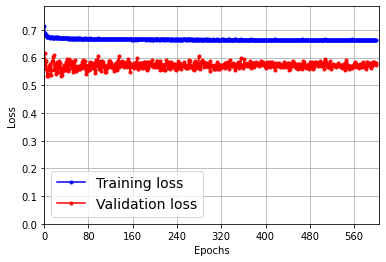

In [25]:
history = model.fit(X_train,y_train,epochs = 600,validation_data=(X_validate,y_validate), verbose=0)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

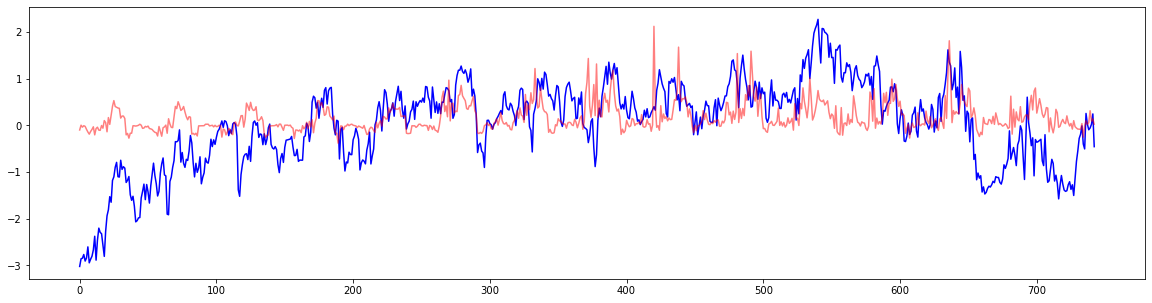

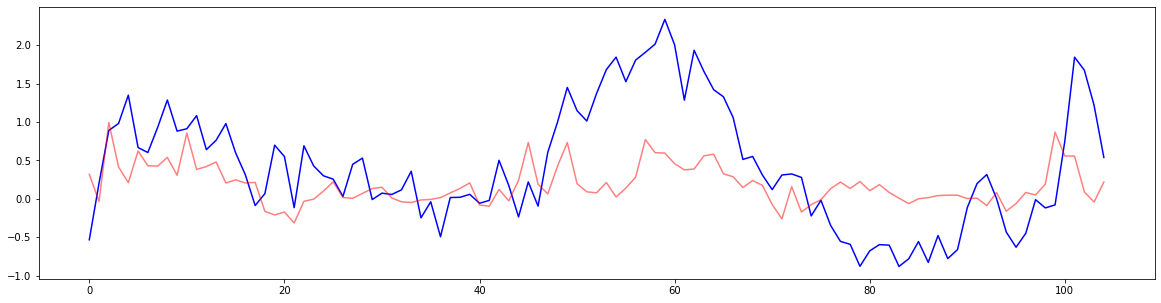

0.6714271755180617


In [26]:
y_pred=model.predict(X_train)
plt.figure(figsize=(20,5))
plt.plot(y_train,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()


y_pred=model.predict(X_validate)
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()

print(np.mean(np.abs((y_pred-y_validate))))

# Prepare for a LSTM Neural Net.
We separate the data in training, validating and test sets. 
Then separate the data into chunks to predict. 

In [170]:
def separate_chunks(X, y, length=12, n_future=1):
    Xs=np.array([X[k:length+k,:] for k in range(X.shape[0]-length+1-n_future)])
    ys=np.array([[y[length+k+n_future-1]] for k in range(X.shape[0]-length-n_future+1)])
    return Xs, ys

In [171]:
date_train='2016-01-01'
date_validate='2018-01-01'
date_test='2019-12-31'
n_future=4

DF=Scaled_DF.copy()
#Drop the Month columns
DF=DF.drop(list(range(12)),axis=1)
DF=DF.dropna(thresh=DF.shape[1]-3).fillna(0)
DF=DF.sort_values('date')

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date'],axis=1))
y_train=np.array(DF_train['energy_generated'])
X_train, y_train=separate_chunks(X_train,y_train,n_future=n_future)

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])
X_validate, y_validate=separate_chunks(X_validate,y_validate,n_future=n_future)

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date'],axis=1))
y_test=np.array(DF_test['energy_generated'])
X_test,y_test=separate_chunks(X_test,y_test,n_future=n_future)

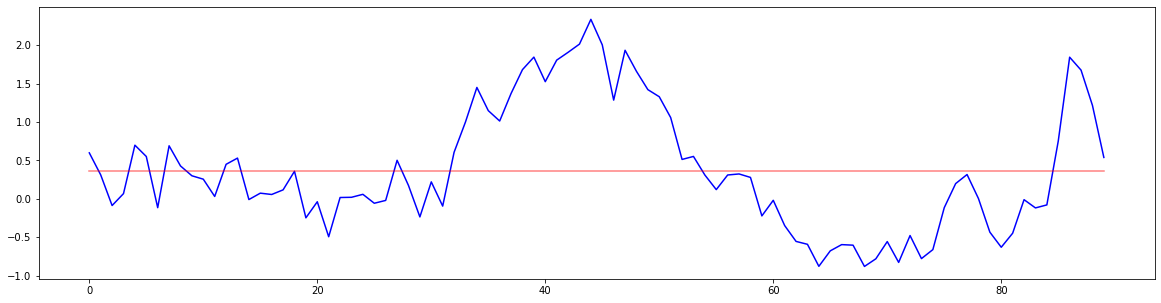

Just the mean:  0.6453523029490832


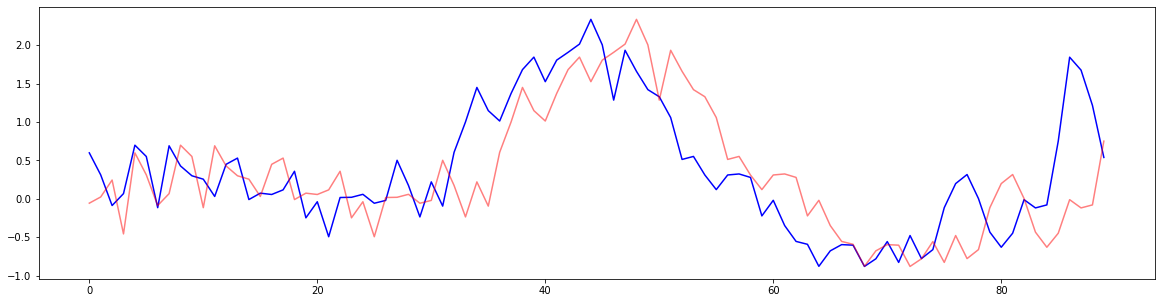

Use last known week: 0.4708644125745031


In [172]:
y_pred=[np.mean(y_validate)]*y_validate.shape[0]
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()
print('Just the mean: ', np.mean(np.abs((y_pred-y_validate))))

y_pred=np.array(list(y_train[-n_future:])+list(y_validate[0:-n_future]))
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()
print('Use last known week:', np.mean(np.abs((y_pred-y_validate))))

In [173]:
model = models.Sequential()
model.add(layers.LSTM(5,input_shape=[None,X_train.shape[2]],return_sequences=True))
model.add(layers.LSTM(5,return_sequences=True))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])

In [174]:
history = model.fit(X_train,y_train,epochs = 100, validation_data=(X_validate,y_validate),verbose=0)

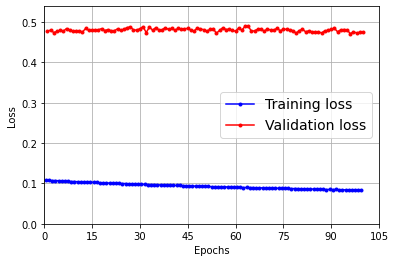

In [119]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

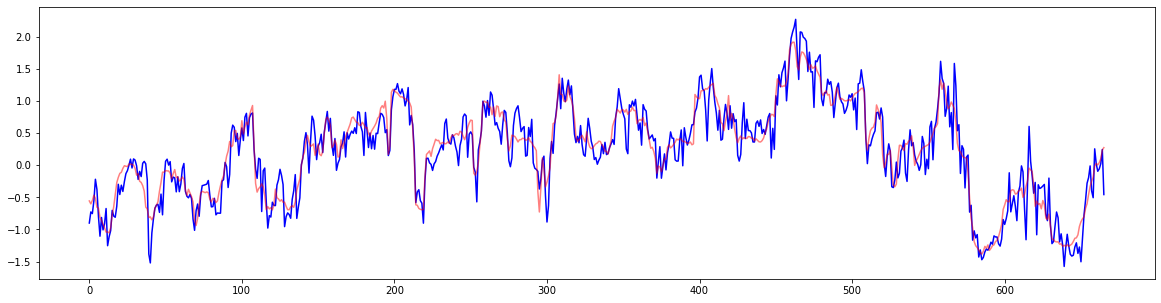

Training:  0.1920167286664727


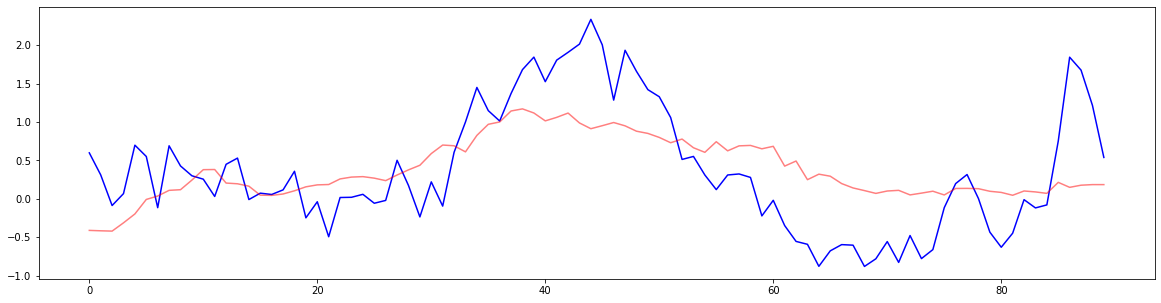

Validating: 0.522291897677416


In [120]:
y_pred=model.predict(X_train)
plt.figure(figsize=(20,5))
plt.plot(y_train,color='blue')
plt.plot(y_pred[:,-1,:],color='red',alpha=0.5)
plt.show()
print('Training: ',np.mean(np.abs((y_pred[:,-1,:]-y_train))))

y_pred=model.predict(X_validate)
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred[:,-1,:],color='red',alpha=0.5)
plt.show()


print('Validating:', np.mean(np.abs((y_pred[:,-1,:]-y_validate))))

## Use just: Rain and previous months of energy_generated

In [175]:
date_train='2016-01-01'
date_validate='2018-01-01'
date_test='2019-12-31'
n_future=4

DF=Scaled_DF.copy()
#Just keep few columns
DF=DF[['energy_generated']+list(Rain1.columns)]
DF=DF[DF.date>=Rain1.date.min()]
DF=DF.fillna(0)
DF=DF.sort_values('date')

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date'],axis=1))
y_train=np.array(DF_train['energy_generated'])
X_train, y_train=separate_chunks(X_train,y_train,n_future=n_future)

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])
X_validate, y_validate=separate_chunks(X_validate,y_validate,n_future=n_future)

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date'],axis=1))
y_test=np.array(DF_test['energy_generated'])
X_test,y_test=separate_chunks(X_test,y_test,n_future=n_future)

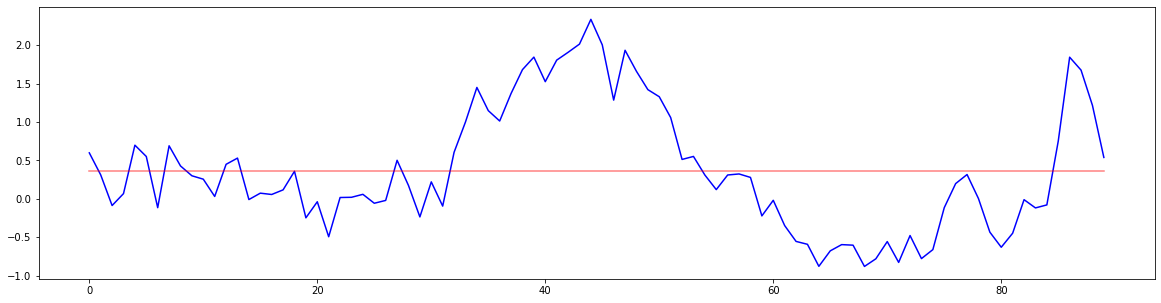

Just the mean:  0.6453523029490832


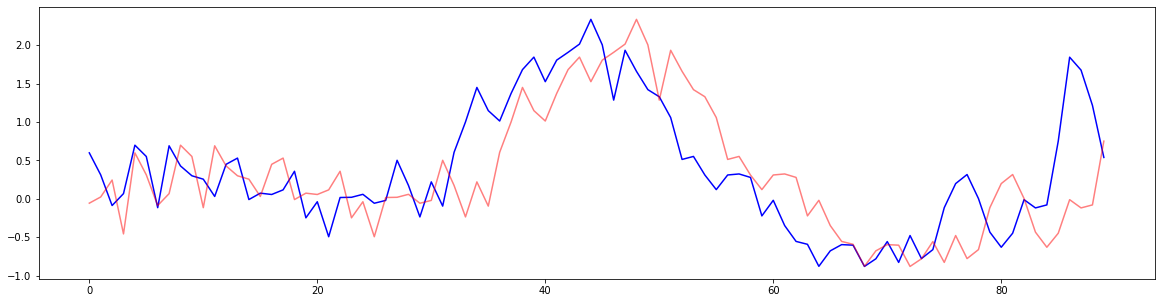

Use last known week: 0.4708644125745031


In [176]:
y_pred=[np.mean(y_validate)]*y_validate.shape[0]
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()
print('Just the mean: ', np.mean(np.abs((y_pred-y_validate))))

y_pred=np.array(list(y_train[-n_future:])+list(y_validate[0:-n_future]))
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()
print('Use last known week:', np.mean(np.abs((y_pred-y_validate))))

In [177]:
model = models.Sequential()
model.add(layers.LSTM(5,input_shape=[None,X_train.shape[2]],return_sequences=True))
model.add(layers.LSTM(5,return_sequences=True))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])

In [178]:
history = model.fit(X_train,y_train,epochs = 100, validation_data=(X_validate,y_validate),verbose=0)

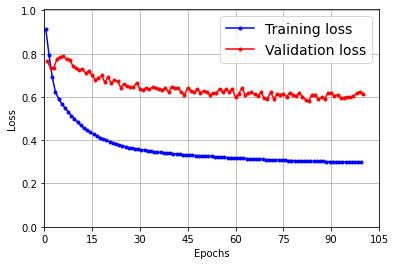

In [179]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

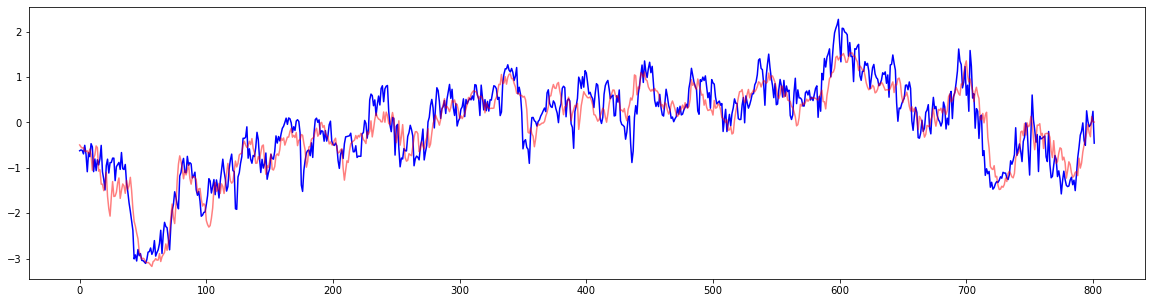

Training:  0.32416359828192426


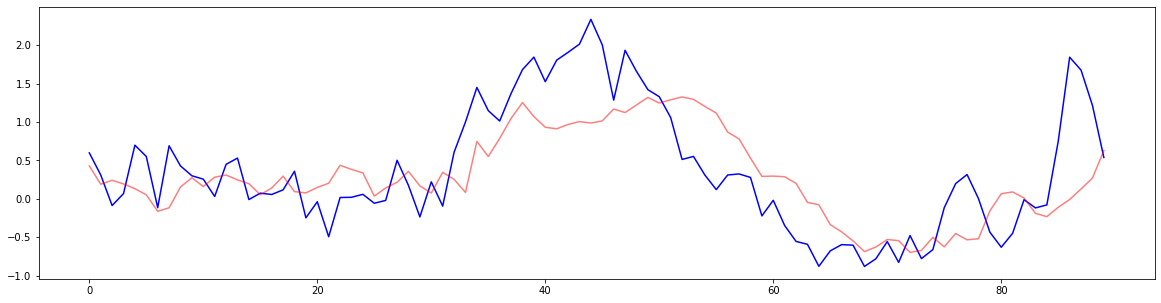

Validating: 0.4436300797394429


In [180]:
y_pred=model.predict(X_train)
plt.figure(figsize=(20,5))
plt.plot(y_train,color='blue')
plt.plot(y_pred[:,-1,:],color='red',alpha=0.5)
plt.show()
print('Training: ',np.mean(np.abs((y_pred[:,-1,:]-y_train))))

y_pred=model.predict(X_validate)
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred[:,-1,:],color='red',alpha=0.5)
plt.show()


print('Validating:', np.mean(np.abs((y_pred[:,-1,:]-y_validate))))

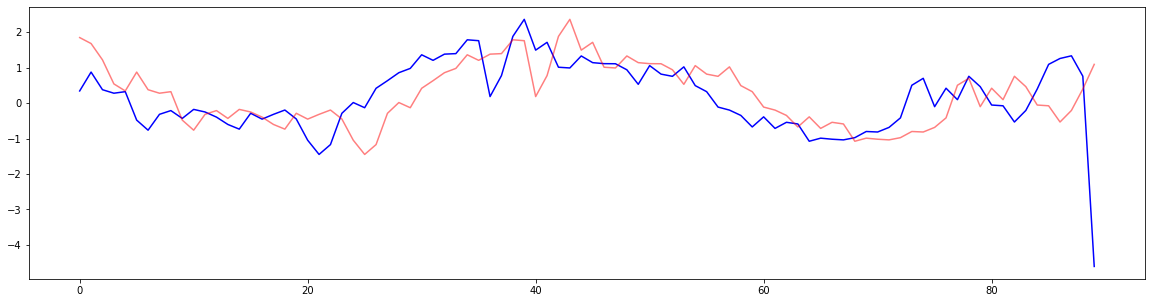

Use last known week: 0.678267375379791


In [183]:
y_pred=model.predict(X_validate)
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred[:,-1,:],color='red',alpha=0.5)
plt.show()
print('Validating:', np.mean(np.abs((y_pred[:,-1,:]-y_validate))))


y_pred=np.array(list(y_validate[-n_future:])+list(y_test[0:-n_future]))
plt.figure(figsize=(20,5))
plt.plot(y_test,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()
print('Use last known week:', np.mean(np.abs((y_pred-y_test))))

## Use just: Previous months of energy_generated

In [156]:
date_train='2016-01-01'
date_validate='2018-01-01'
date_test='2019-12-31'
n_future=4
length=36

DF=Scaled_DF.copy()
#Just keep few columns
DF=DF[['energy_generated']+list(Rain1.columns)]
DF=DF[DF.date>=Rain1.date.min()]
DF=DF.fillna(0)
DF=DF.sort_values('date')

DF_train=DF[DF.date<=date_train]
X_train=np.array(DF_train.drop(['date'],axis=1))
y_train=np.array(DF_train['energy_generated'])
X_train, y_train=separate_chunks(X_train,y_train,n_future=n_future,length=length)

DF_validate=DF[(DF.date>date_train) & (DF.date<=date_validate)]
X_validate=np.array(DF_validate.drop(['date'],axis=1))
y_validate=np.array(DF_validate['energy_generated'])
X_validate, y_validate=separate_chunks(X_validate,y_validate,n_future=n_future,length=length)

DF_test=DF[(DF.date>date_validate) & (DF.date<=date_test)]
X_test=np.array(DF_test.drop(['date'],axis=1))
y_test=np.array(DF_test['energy_generated'])
X_test,y_test=separate_chunks(X_test,y_test,n_future=n_future,length=length)

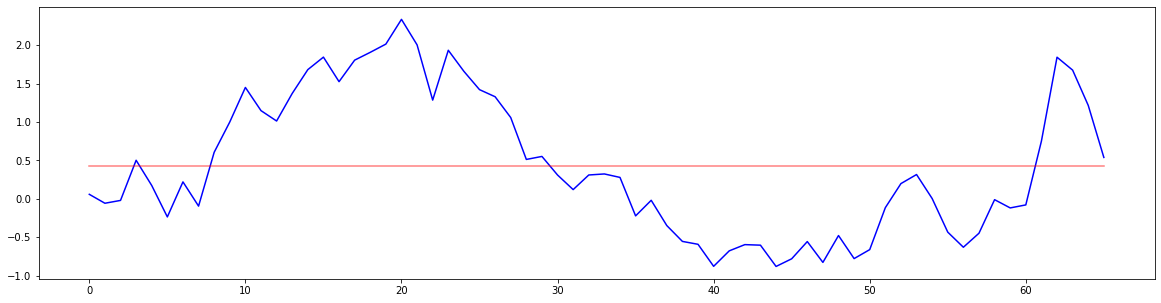

Just the mean:  0.7835742703851679


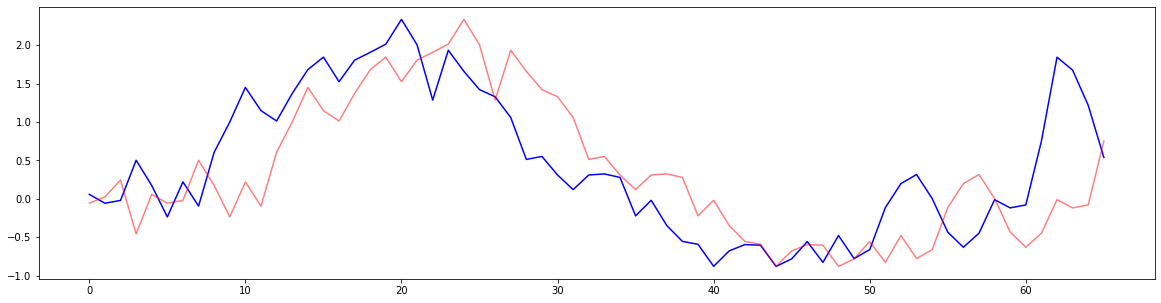

Use last known week: 0.5308493297411901


In [157]:
y_pred=[np.mean(y_validate)]*y_validate.shape[0]
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()
print('Just the mean: ', np.mean(np.abs((y_pred-y_validate))))

y_pred=np.array(list(y_train[-n_future:])+list(y_validate[0:-n_future]))
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred,color='red',alpha=0.5)
plt.show()
print('Use last known week:', np.mean(np.abs((y_pred-y_validate))))

In [158]:
model = models.Sequential()
model.add(layers.LSTM(5,input_shape=[None,X_train.shape[2]],return_sequences=True))
model.add(layers.LSTM(5,return_sequences=True))
model.add(layers.Dense(1))
#model.summary()
model.compile(optimizer='rmsprop',loss='mse', metrics=['mae'])

In [164]:
history = model.fit(X_train,y_train,epochs = 100, validation_data=(X_validate,y_validate),verbose=0)

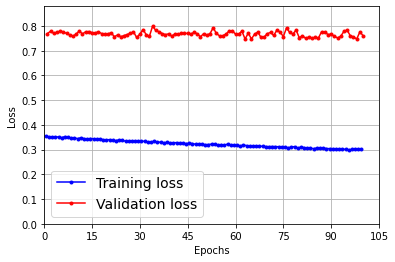

In [165]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

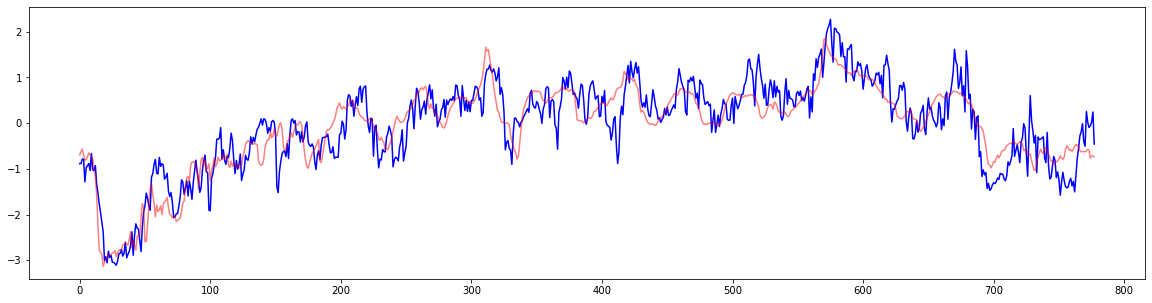

Training:  0.36602238004478393


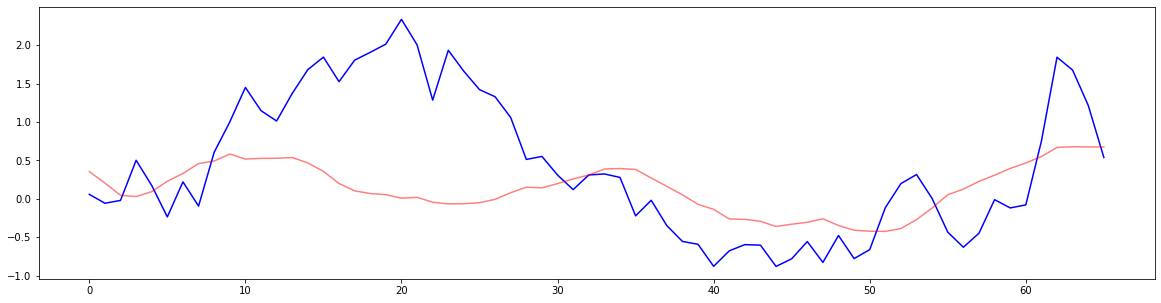

Validating: 0.7956358676062701


In [167]:
y_pred=model.predict(X_train)
plt.figure(figsize=(20,5))
plt.plot(y_train,color='blue')
plt.plot(y_pred[:,-1,:],color='red',alpha=0.5)
plt.show()
print('Training: ',np.mean(np.abs((y_pred[:,-1,:]-y_train))))

y_pred=model.predict(X_validate)
plt.figure(figsize=(20,5))
plt.plot(y_validate,color='blue')
plt.plot(y_pred[:,-1,:],color='red',alpha=0.5)
plt.show()


print('Validating:', np.mean(np.abs((y_pred[:,-1,:]-y_validate))))